In [163]:
import os
import re
import itertools
import pickle
from collections import Counter,defaultdict
try:
	import pandas as pd
	import numpy as np
	from nltk.corpus import stopwords
	from nltk.stem import PorterStemmer
	import gensim
	from gensim.models import Word2Vec
	from nltk.stem import WordNetLemmatizer
	from keras.utils import np_utils
except:
	print("require modules: keras,gensim,nltk.stem,nltk.corpus,nltk.stem, please install it.")
	exit()

In [164]:
reg1 = re.compile("\.txt$")
reg2 = re.compile("([0-9]+)\.txt")
reg3 = re.compile(".*_([0-9])\.txt")
reg4 = re.compile("\[.+\]")
reg5 = re.compile("info\.txt")
lyrics_dic = {}
#iter all directory and load all song(txt file)
for i in os.listdir():
    if os.path.isdir(i):
        for path,sub,items in os.walk(i):
            if any([reg1.findall(item) for item in items]):
                for item in items:
                    if reg5.findall(item):
                        continue
                    if reg3.findall(item):
                        num = ["0"+reg3.findall(item)[0]]
                        name = "_".join(path.split("/") + num)
                    else:
                        name = "_".join(path.split("/") + reg2.findall(item))

                    with open(os.path.join(path,item),"r",encoding="utf8", errors='ignore') as f:
                        lyrics = "".join(f.readlines())
                        lyrics = reg4.subn("",lyrics)[0]
                        lyrics_dic[name] = lyrics

In [165]:
len(lyrics_dic.keys())

777

In [166]:
df=pd.DataFrame(columns=["lyrics","mood"])

In [167]:
for key in lyrics_dic.keys():
    #print(key)
    if "Happy" in key:
        
        df=df.append({"lyrics":lyrics_dic[key],"mood":"1"},ignore_index=True)
    elif "Sad" in key:
        df=df.append({"lyrics":lyrics_dic[key],"mood":"2"},ignore_index=True)
    elif "Angry" in key:
        df=df.append({"lyrics":lyrics_dic[key],"mood":"3"},ignore_index=True)
    elif "Relaxed" in key:
        df=df.append({"lyrics":lyrics_dic[key],"mood":"4"},ignore_index=True)

In [168]:
df.head()

,lyrics,mood
0,Put your lips close to mine\nAs long as they d...,1
1,"My lullaby,hung out to dry\nWhat's up with tha...",1
2,Though you've played at love and lost\nAnd sor...,1
3,we know we are the ones\nwho do it numb again\...,1
4,Another day has come and gone\nThey fade away ...,1


In [169]:
df = df.sample(frac=1).reset_index(drop=True)

In [170]:
df_new=pd.read_csv("df_mood_backup.csv")

In [171]:
df_new.tail()

,Unnamed: 0,file,artist,title,lyrics,tags,mood
600,9913,TRAREDZ12903CFB6E3.h5,Pelle Carlberg,Clever Girls Like Clever Boys Much More Than C...,You should have listened to what mama said\nAn...,"['handclaps', 'title is a full sentence', 'ind...",1
601,9943,TRATTMT128F149167B.h5,Michael Jackson,Ain't No Sunshine,Spoken Intro:\nYou ever want something\nThat y...,"['soul', 'michael jackson', '70s', 'pop', 'cov...",2
602,9966,TRAWFGF128E0792FE0.h5,Extreme,Stop The World,All the world's a masquerade\nMade up of fools...,"['hard rock', 'rock', 'funk metal', 'Power bal...",2
603,9967,TRAWFVE128F42912CA.h5,Dimmu Borgir,Sympozium,Chains of despair cloacked by darkness\nThe th...,"['Symphonic Black Metal', 'black metal', 'melo...",3
604,9969,TRBDMIN128F147FCBB.h5,Phil Collins,One More Night,One more night\nOne more night\n\nI've been tr...,"['80s', 'pop', 'Phil Collins', 'soft rock', 'r...",2


In [172]:
df_new=df_new[["lyrics","mood"]]

In [173]:
df3=df.append(df_new,ignore_index=True)

In [174]:
df3["mood"]=df3["mood"].apply(str)

In [175]:
df3.shape

(1382, 2)

In [176]:
set(df3["mood"].values)
df=df3

In [107]:
data_X = df['lyrics'].values
data_Y = df['mood'].values
import nltk
import string
import re

porter_stemmer = nltk.stem.porter.PorterStemmer()
def porter_tokenizer(text, stemmer=porter_stemmer):
    lower_txt = text.lower()
    tokens = nltk.wordpunct_tokenize(lower_txt)
    stems = [porter_stemmer.stem(t) for t in tokens]
    no_punct = [s for s in stems if re.match('^[a-zA-Z]+$', s) is not None]
    return no_punct
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(
            encoding='utf-8',
            decode_error='replace',
            strip_accents='unicode',
            analyzer='word',
            binary=False,
            stop_words="english",
            tokenizer=porter_tokenizer
    )

In [108]:



data_X = tfidf.fit_transform(data_X)




In [121]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_X, data_Y, test_size=0.4, random_state=0)

In [122]:

from sklearn.svm import LinearSVC
import sklearn.metrics as metrics
classifier_rbf = LinearSVC(multi_class="ovr")
classifier_rbf.fit(X_train, y_train)
prediction_rbf = classifier_rbf.predict(X_test)
from sklearn.metrics import classification_report,accuracy_score
def prediction_evaluation(model_name,model,test_X,test_Y):
    y_pred = model.predict(test_X)
    cm = metrics.confusion_matrix(test_Y, y_pred)
    print(cm)
    print(classification_report(test_Y, y_pred))
    print(accuracy_score(test_Y, y_pred))
prediction_evaluation("SVM",classifier_rbf,X_test,y_test)

[[93 50  2 22]
 [46 98 15 37]
 [17 29 25  8]
 [21 56  3 31]]
              precision    recall  f1-score   support

           1       0.53      0.56      0.54       167
           2       0.42      0.50      0.46       196
           3       0.56      0.32      0.40        79
           4       0.32      0.28      0.30       111

   micro avg       0.45      0.45      0.45       553
   macro avg       0.45      0.41      0.42       553
weighted avg       0.45      0.45      0.44       553

0.44665461121157324


In [123]:
from sklearn.naive_bayes import MultinomialNB
clf_NB = MultinomialNB()
clf_NB.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [124]:
prediction_evaluation("MultinomialNB",clf_NB,X_test,y_test)

[[ 24 143   0   0]
 [  7 189   0   0]
 [  5  74   0   0]
 [  5 106   0   0]]
              precision    recall  f1-score   support

           1       0.59      0.14      0.23       167
           2       0.37      0.96      0.53       196
           3       0.00      0.00      0.00        79
           4       0.00      0.00      0.00       111

   micro avg       0.39      0.39      0.39       553
   macro avg       0.24      0.28      0.19       553
weighted avg       0.31      0.39      0.26       553

0.38517179023508136


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [125]:
from sklearn.neural_network import MLPClassifier
clf_mlp=MLPClassifier(hidden_layer_sizes=(500,200,), activation='relu', solver='adam', max_iter=1000,alpha=0.001)
clf_mlp.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(500, 200), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [126]:
prediction_evaluation("MLPClassifier",clf_mlp,X_test,y_test)

[[ 83  51   4  29]
 [ 43 110  11  32]
 [ 15  33  24   7]
 [ 24  63   1  23]]
              precision    recall  f1-score   support

           1       0.50      0.50      0.50       167
           2       0.43      0.56      0.49       196
           3       0.60      0.30      0.40        79
           4       0.25      0.21      0.23       111

   micro avg       0.43      0.43      0.43       553
   macro avg       0.45      0.39      0.40       553
weighted avg       0.44      0.43      0.43       553

0.43399638336347196


In [127]:
from sklearn.linear_model import LogisticRegressionCV
clf_lg=LogisticRegressionCV(max_iter=5000,multi_class="multinomial")
clf_lg.fit(X_train,y_train)
prediction_evaluation("logistic",clf_lg,X_test,y_test)

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


[[ 87  59   2  19]
 [ 45 119   7  25]
 [ 17  36  20   6]
 [ 21  65   1  24]]
              precision    recall  f1-score   support

           1       0.51      0.52      0.52       167
           2       0.43      0.61      0.50       196
           3       0.67      0.25      0.37        79
           4       0.32      0.22      0.26       111

   micro avg       0.45      0.45      0.45       553
   macro avg       0.48      0.40      0.41       553
weighted avg       0.47      0.45      0.44       553

0.45207956600361665


In [205]:
from sklearn.linear_model import LogisticRegressionCV
clf_lg=LogisticRegressionCV(max_iter=5000,multi_class="multinomial")
clf_lg.fit(xtrain_tfidf_ngram,train_y)
prediction_evaluation("logistic",clf_lg,xvalid_tfidf_ngram,valid_y)

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


[[ 47  65   3  12]
 [ 39 106  10  20]
 [  4  14   2   1]
 [ 16  33   1   8]]
              precision    recall  f1-score   support

           0       0.44      0.37      0.40       127
           1       0.49      0.61      0.54       175
           2       0.12      0.10      0.11        21
           3       0.20      0.14      0.16        58

   micro avg       0.43      0.43      0.43       381
   macro avg       0.31      0.30      0.30       381
weighted avg       0.41      0.43      0.41       381

0.42782152230971127


In [60]:
data_k="now i cant live without you,i'm nothing without you.now i cant live without you, nothing without you.if i go away from you, be away from myself.because its only you,now its only you,you are my life now,peace in me and the pain too,now my love is just you. whats the relation between you and me!that i cant get away for a moment... i live for you everyday,i give every moment of my life to you.there's no moment without you,there's your name in every breath. because its only you,now its only you,you are my life now,peace in me and the pain too,You are my love,cause its only you,because its only you,now my love is just you"

In [30]:
data_k=tfidf.fit_transform([data_k])

In [33]:
print(data_k)

  (0, 8)	0.2750095491084634
  (0, 10)	0.09166984970282113
  (0, 12)	0.18333969940564226
  (0, 0)	0.2750095491084634
  (0, 1)	0.2750095491084634
  (0, 13)	0.5500190982169268
  (0, 7)	0.2750095491084634
  (0, 15)	0.18333969940564226
  (0, 14)	0.18333969940564226
  (0, 9)	0.2750095491084634
  (0, 6)	0.18333969940564226
  (0, 16)	0.09166984970282113
  (0, 11)	0.2750095491084634
  (0, 5)	0.09166984970282113
  (0, 4)	0.18333969940564226
  (0, 17)	0.18333969940564226
  (0, 2)	0.09166984970282113
  (0, 3)	0.09166984970282113


In [116]:
clf_lg.predict(data_k)

ValueError: X has 18 features per sample; expecting 6145

In [117]:
X_test[0]

<1x6145 sparse matrix of type '<class 'numpy.float64'>'
	with 69 stored elements in Compressed Sparse Row format>

In [61]:
data_m = df['lyrics'].values
data_m=np.append(data_m,data_k)

In [62]:
z=tfidf.fit_transform(data_m)

In [63]:
print(z.shape)

(778, 6145)


In [66]:
classifier_rbf.predict(z[777])

array(['4'], dtype=object)

In [161]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.ensemble import RandomForestClassifier
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/manojitpc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/manojitpc/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [177]:
df['lyrics'] = [entry.lower() for entry in df['lyrics']]
df['lyrics']= [word_tokenize(entry) for entry in df['lyrics']]


In [180]:
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
for index,entry in enumerate(df['lyrics']):
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    df.loc[index,'text_final'] = str(Final_words)

In [179]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/manojitpc/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [183]:
df.shape

(1382, 3)

In [221]:
data=df[["text_final","mood"]]
data_x=df["text_final"]
data_y=df["mood"]

In [256]:
from sklearn.model_selection import train_test_split
train_x,valid_x,train_y,valid_y = train_test_split(data_x, data_y, test_size=0.3, random_state=0)

In [269]:
train_x = df['text_final'][0:1000]
valid_x = df['text_final'][1001:1382]
train_y = df['mood'][0:1000]
valid_y = df['mood'][1001:1382]

In [270]:
Encoder = LabelEncoder()
train_y = Encoder.fit_transform(train_y)
valid_y = Encoder.fit_transform(valid_y)

In [271]:
all_texts = []

for items in train_x:
    all_texts.append(items)
    
for items in valid_x:
    all_texts.append(items)


In [272]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import pandas,numpy,xgboost, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

In [273]:
count_vect = CountVectorizer(analyzer='word')
count_vect.fit(all_texts)
xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)

In [274]:
tfidf_vect = TfidfVectorizer(analyzer='word',max_features=5000)
tfidf_vect.fit(all_texts)
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

tfidf_vect_ngram = TfidfVectorizer(analyzer='word', ngram_range=(2,2), max_features=5000)
tfidf_vect_ngram.fit(all_texts)
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)


In [275]:
valid_y.shape

(381,)

In [276]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    classifier.fit(feature_vector_train, label)
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y)

In [277]:
accuracy_count_nb = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count)
print ("NB, Count Vectors: ", accuracy_count_nb)

accuracy_word_nb = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("NB, WordLevel TF-IDF: ", accuracy_word_nb)

accuracy_ngram_nb = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("NB, N-Gram Vectors: ", accuracy_ngram_nb)

NB, Count Vectors:  0.48293963254593175
NB, WordLevel TF-IDF:  0.5301837270341208
NB, N-Gram Vectors:  0.4776902887139108


In [278]:
accuracy_count_rf = train_model(RandomForestClassifier(n_estimators=100),xtrain_count,train_y,xvalid_count)
print("RF, Count Vectors: ",accuracy_count_rf)

accuracy_word_rf = train_model(RandomForestClassifier(n_estimators=100),xtrain_tfidf,train_y,xvalid_tfidf)
print("RF, WordLevel TF-IDF Vectors: ",accuracy_word_rf)

accuracy_ngram_rf = train_model(RandomForestClassifier(n_estimators=100),xtrain_tfidf_ngram,train_y,xvalid_tfidf_ngram)
print("RF, N-Gram Vectors: ",accuracy_ngram_rf)

RF, Count Vectors:  0.48556430446194226
RF, WordLevel TF-IDF Vectors:  0.49606299212598426
RF, N-Gram Vectors:  0.3779527559055118


In [279]:
accuracy_count_lc = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count)
print ("LR, Count Vectors: ", accuracy_count_lc)

accuracy_word_lc = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("LR, WordLevel TF-IDF: ", accuracy_word_lc)

accuracy_ngram_lc = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("LR, N-Gram Vectors: ", accuracy_ngram_lc)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LR, Count Vectors:  0.3910761154855643
LR, WordLevel TF-IDF:  0.5091863517060368
LR, N-Gram Vectors:  0.48293963254593175


In [280]:
accuracy_count_bo = train_model(xgboost.XGBClassifier(), xtrain_count.tocsc(), train_y, xvalid_count.tocsc())
print ("Xgb, Count Vectors: ", accuracy_count_bo)

accuracy_word_bo = train_model(xgboost.XGBClassifier(), xtrain_tfidf.tocsc(), train_y, xvalid_tfidf.tocsc())
print ("Xgb, WordLevel TF-IDF: ", accuracy_word_bo)

accuracy_ngram_bo = train_model(xgboost.XGBClassifier(), xtrain_tfidf_ngram.tocsc(), train_y, xvalid_tfidf_ngram.tocsc())
print ("Xgb, Ngram Level Vectors: ", accuracy_ngram_bo)

Xgb, Count Vectors:  0.4409448818897638
Xgb, WordLevel TF-IDF:  0.44881889763779526
Xgb, Ngram Level Vectors:  0.4671916010498688


In [281]:
accuracy_count_bg = train_model(ensemble.RandomForestClassifier(), xtrain_count, train_y, xvalid_count)
print ("RF, Count Vectors: ", accuracy_count_bg)

accuracy_word_bg = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("RF, WordLevel TF-IDF: ", accuracy_word_bg)

accuracy_ngram_bg = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("RF, Ngram Vectors: ", accuracy_ngram_bg)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF, Count Vectors:  0.45931758530183725
RF, WordLevel TF-IDF:  0.3858267716535433


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF, Ngram Vectors:  0.3674540682414698


In [285]:
import matplotlib as mpl
import numpy as np

def plot_cm(X, y, clf, title):

    cm = metrics.confusion_matrix(y, clf.predict(X))

    np.set_printoptions(suppress=True)
    mpl.rc("figure", figsize=(10,10))

    hm = sns.heatmap(cm, 
            cbar=False,
            annot=True, 
            square=True,
            fmt='d',
            yticklabels=['happy','sad','angry','relaxed'],
            xticklabels=['happy','sad','angry','relaxed'],
            cmap='Blues'
            )
    plt.title(title)
    plt.ylabel('actual class')
    plt.xlabel('predicted class')
    plt.tight_layout()
    plt.show()

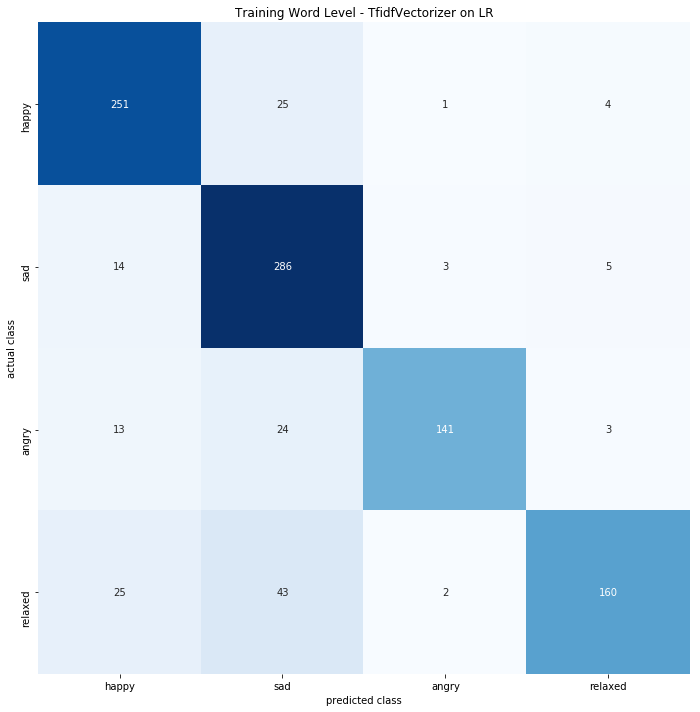

In [286]:
import seaborn as sns
import matplotlib.pyplot as plt

claf = linear_model.LogisticRegression()
claf.fit(xtrain_tfidf, train_y)
plot_cm(xtrain_tfidf, train_y, claf, 'Training Word Level - TfidfVectorizer on LR')

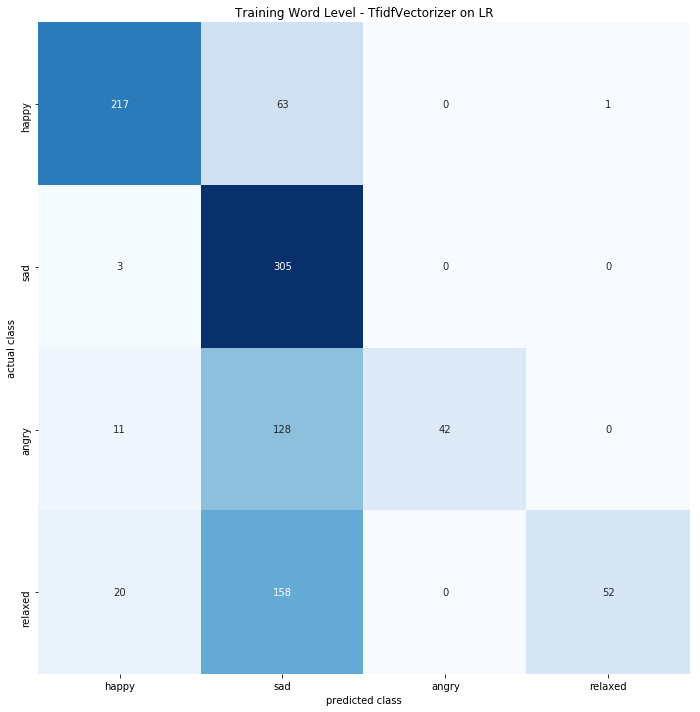

In [288]:
import seaborn as sns
import matplotlib.pyplot as plt

claf = naive_bayes.MultinomialNB()
claf.fit(xtrain_tfidf, train_y)
plot_cm(xtrain_tfidf, train_y, claf, 'Training Word Level - TfidfVectorizer on LR')